# Convolutional Neural Network (CNN)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.7.0+cu101].
device:[cuda:0].


### Dataset

In [2]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
print ("mnist_train:\n",mnist_train,"\n")
print ("mnist_test:\n",mnist_test,"\n")
print ("Done.")

mnist_train:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor() 

mnist_test:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor() 

Done.


### Data Iterator

In [3]:
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
print ("Done.")

Done.


### Define Model

In [4]:
class ConvolutionalNeuralNetworkClass(nn.Module):
    """
        Convolutional Neural Network (CNN) Class
    """
    def __init__(self,name='cnn',xdim=[1,28,28],ksize=(3,3),hdims=[32,64],ydim=10):
        super(ConvolutionalNeuralNetworkClass,self).__init__()
        self.name = name
        self.xdim = xdim
        self.ksize = ksize
        self.hdims = hdims
        self.ydim = ydim

        self.layers = []
        prev_dim = self.xdim[0]
        for l_idx in range(len(self.hdims)): # for each hidden layer
            hdim = self.hdims[l_idx]
            self.layers.append(
                nn.Conv2d(in_channels=prev_dim,
                          out_channels=hdim,
                          kernel_size=self.ksize,
                          stride=(1,1),
                          padding=self.ksize//2)) # convlution 
            self.layers.append(nn.BatchNorm2d(hdim)) # batch-norm
            self.layers.append(nn.ReLU(True))  # activation
            self.layers.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))) # max-pooling 
            self.layers.append(nn.Dropout2d(p=0.5))  # dropout
            prev_dim = hdim
        self.layers.append(nn.Flatten())
        fdim = int(self.xdim[1]/2**len(self.hdims))
        self.layers.append(nn.Linear(fdim*fdim*prev_dim,self.ydim,bias=True))

        # Concatenate all layers 
        self.net = nn.Sequential()
        for l_idx,layer in enumerate(self.layers):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
            self.net.add_module(layer_name,layer)
        self.init_param() # initialize parameters
        
    def init_param(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.BatchNorm2d): # init BN
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            
    def forward(self,x):
        return self.net(x)

C = ConvolutionalNeuralNetworkClass(
    name='cnn',xdim=[1,28,28],ksize=3,hdims=[32,64],ydim=10).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(C.parameters(),lr=1e-3)
print ("Done.")

Done.


### Print Computational Graph

In [5]:
print (C.net)

Sequential(
  (conv2d_00): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2d_01): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_02): ReLU(inplace=True)
  (maxpool2d_03): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout2d_04): Dropout2d(p=0.5, inplace=False)
  (conv2d_05): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2d_06): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_07): ReLU(inplace=True)
  (maxpool2d_08): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout2d_09): Dropout2d(p=0.5, inplace=False)
  (flatten_10): Flatten(start_dim=1, end_dim=-1)
  (linear_11): Linear(in_features=3136, out_features=10, bias=True)
)


### Check Parameters

In [6]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx,(param_name,param) in enumerate(C.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy() # to numpy array 
        n_param += len(param_numpy.reshape(-1))
        print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
        print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

[0] name:[net.conv2d_00.weight] shape:[(32, 1, 3, 3)].
    val:[0.004 0.126 0.099 0.982 0.1  ]
[1] name:[net.conv2d_00.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]
[2] name:[net.batchnorm2d_01.weight] shape:[(32,)].
    val:[1. 1. 1. 1. 1.]
[3] name:[net.batchnorm2d_01.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]
[4] name:[net.conv2d_05.weight] shape:[(64, 32, 3, 3)].
    val:[-0.138  0.061 -0.113 -0.073  0.003]
[5] name:[net.conv2d_05.bias] shape:[(64,)].
    val:[0. 0. 0. 0. 0.]
[6] name:[net.batchnorm2d_06.weight] shape:[(64,)].
    val:[1. 1. 1. 1. 1.]
[7] name:[net.batchnorm2d_06.bias] shape:[(64,)].
    val:[0. 0. 0. 0. 0.]
[8] name:[net.linear_11.weight] shape:[(10, 3136)].
    val:[ 6.946e-03  2.945e-03 -6.888e-05 -3.484e-02 -1.655e-02]
[9] name:[net.linear_11.bias] shape:[(10,)].
    val:[0. 0. 0. 0. 0.]
Total number of parameters:[50,378].


### Simple Forward Path of the CNN Model

In [7]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
x_numpy = np.random.rand(2,1,28,28)
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = C.forward(x_torch) # forward path
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array
print ("x_torch:\n",x_torch)
print ("y_torch:\n",y_torch)
print ("\nx_numpy %s:\n"%(x_numpy.shape,),x_numpy)
print ("y_numpy %s:\n"%(y_numpy.shape,),y_numpy)

x_torch:
 tensor([[[[0.062, 0.383, 0.613,  ..., 0.803, 0.998, 0.644],
          [0.635, 0.508, 0.027,  ..., 0.214, 0.301, 0.795],
          [0.598, 0.680, 0.066,  ..., 0.460, 0.645, 0.841],
          ...,
          [0.970, 0.438, 0.267,  ..., 0.757, 0.864, 0.175],
          [0.442, 0.961, 0.508,  ..., 0.093, 0.424, 0.175],
          [0.089, 0.106, 0.852,  ..., 0.375, 0.766, 0.450]]],


        [[[0.459, 0.296, 0.351,  ..., 0.995, 0.740, 0.365],
          [0.214, 0.115, 0.320,  ..., 0.990, 0.894, 0.833],
          [0.241, 0.653, 0.915,  ..., 0.254, 0.174, 0.945],
          ...,
          [0.398, 0.833, 0.371,  ..., 0.396, 0.009, 0.254],
          [0.998, 0.793, 0.887,  ..., 0.808, 0.090, 0.289],
          [0.305, 0.633, 0.269,  ..., 0.874, 0.020, 0.028]]]], device='cuda:0')
y_torch:
 tensor([[ 0.913,  0.338,  1.007,  2.761, -2.191, -3.763, -3.404,  0.778,  3.426,
         -1.493],
        [ 0.255, -1.447,  0.419,  3.388,  0.592,  0.626, -1.775,  3.474, -0.602,
          0.768]], device=

### Evaluation Function

In [8]:
def func_eval(model,data_iter,device,batch_size=256):
    with torch.no_grad():
        n_total,n_correct = 0,0
        model.eval() # evaluate (affects DropOut and BN)
        for batch_in,batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model(batch_in.view(-1,1,28,28).to(device))
            _,y_pred = torch.max(model_pred.data,1)
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
    return val_accr
print ("Done")

Done


### Initial Evaluation

In [9]:
C.init_param() # initialize parameters
train_accr = func_eval(C,train_iter,device,batch_size=256)
test_accr = func_eval(C,test_iter,device,batch_size=256)
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

train_accr:[0.115] test_accr:[0.106].


### Train

In [10]:
print ("Start training.")
C.init_param() # initialize parameters
C.train() # to train mode 
EPOCHS,print_every = 10,1
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in,batch_out in train_iter:
        # Forward path
        y_pred = C.forward(batch_in.view(-1,1,28,28).to(device))
        loss_out = loss(y_pred,batch_out.to(device))
        # Update
        optm.zero_grad() # reset gradient 
        loss_out.backward() # backpropagate
        optm.step() # optimizer update
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter)
    # Print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr = func_eval(C,train_iter,device,batch_size=256)
        test_accr = func_eval(C,test_iter,device,batch_size=256)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (epoch,loss_val_avg,train_accr,test_accr))
print ("Done")

Start training.
epoch:[0] loss:[0.538] train_accr:[0.959] test_accr:[0.962].
epoch:[1] loss:[0.097] train_accr:[0.979] test_accr:[0.980].
epoch:[2] loss:[0.061] train_accr:[0.985] test_accr:[0.982].
epoch:[3] loss:[0.048] train_accr:[0.989] test_accr:[0.986].
epoch:[4] loss:[0.038] train_accr:[0.992] test_accr:[0.988].
epoch:[5] loss:[0.033] train_accr:[0.993] test_accr:[0.988].
epoch:[6] loss:[0.026] train_accr:[0.995] test_accr:[0.990].
epoch:[7] loss:[0.023] train_accr:[0.994] test_accr:[0.988].
epoch:[8] loss:[0.020] train_accr:[0.997] test_accr:[0.990].
epoch:[9] loss:[0.016] train_accr:[0.996] test_accr:[0.987].
Done


### Test

Done


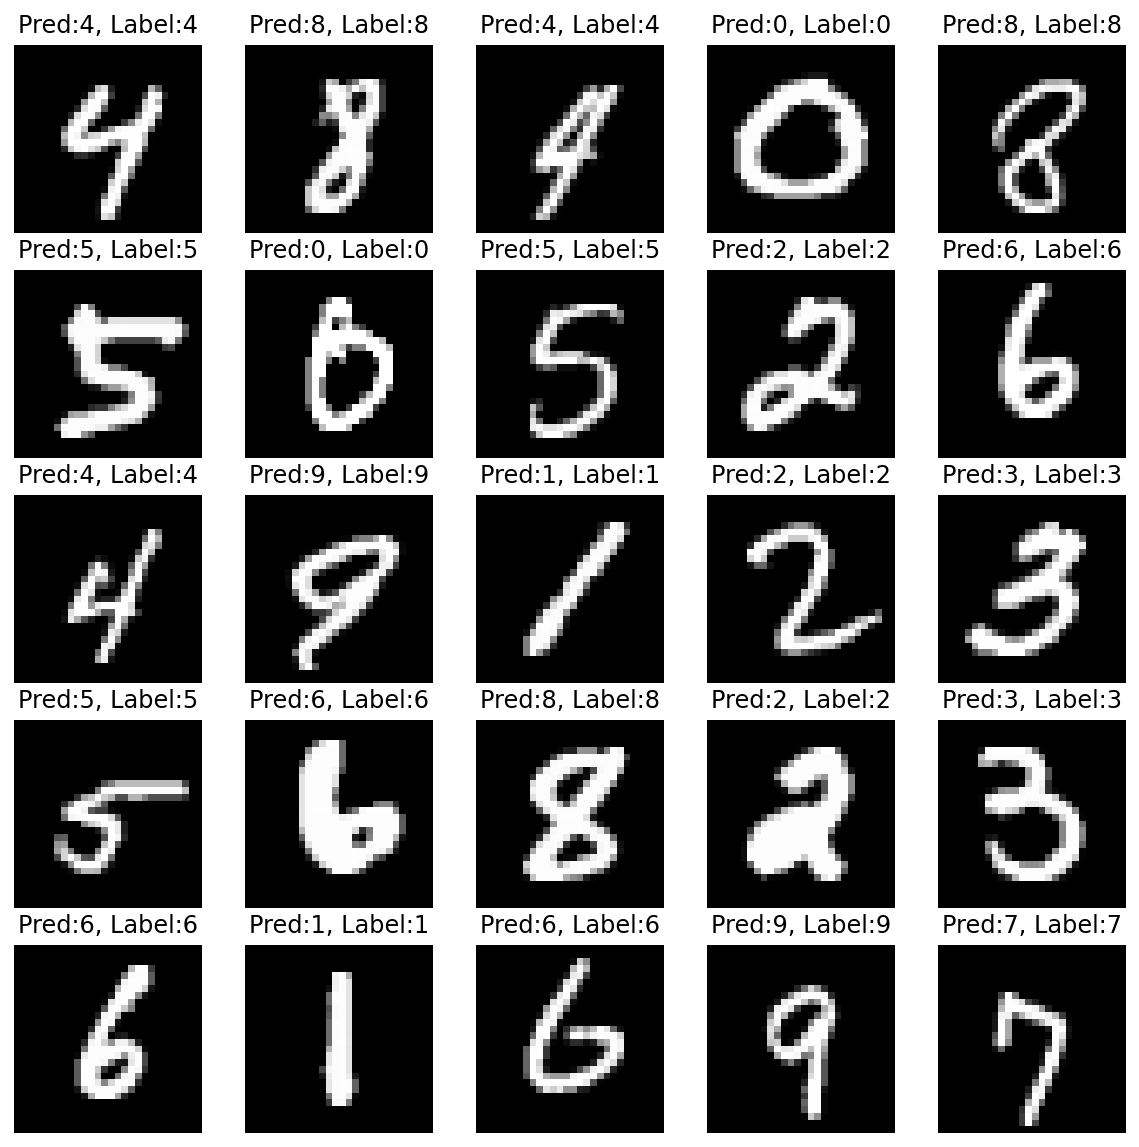

In [11]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets),n_sample,replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]
with torch.no_grad():
    C.eval() # to evaluation mode 
    y_pred = C.forward(test_x.view(-1,1,28,28).type(torch.float).to(device))
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))
print ("Done")